In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.applications import EfficientNetB1,EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
import random

# load the efficientB0 model

In [25]:
train_path = r'whole_image'

In [26]:
labels=os.listdir(train_path)
labels

['1', '2', '3', 'normal']

In [27]:
X_train = []
y_train = []
image_size =320
for i in labels:
    folderPath = os.path.join(train_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [28]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [29]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
print(X_train.shape)

(1280, 320, 320, 3)


In [30]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.125,random_state=101)

In [31]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [32]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [33]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 320, 320, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 320, 320, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 321, 321, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

# Training the model with our data and save it

In [34]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'whole_logs')
checkpoint = ModelCheckpoint("whole_image.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [36]:
hist = model.fit(X_train,y_train,validation_split=0.125, epochs =12, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\28261\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/12
62/62 [==============================] - 449s 7s/step - loss: 0.8409 - accuracy: 0.6469 - val_loss: 0.8453 - val_accuracy: 0.7000

Epoch 00001: val_accuracy improved from -inf to 0.70000, saving model to whole_image.h5
Epoch 2/12
62/62 [==============================] - 424s 7s/step - loss: 0.3268 - accuracy: 0.8837 - val_loss: 0.5176 - val_accuracy: 0.8214

Epoch 00002: val_accuracy improved from 0.70000 to 0.82143, saving model to whole_image.h5
Epoch 3/12
62/62 [==============================] - 425s 7s/step - loss: 0.2135 - accuracy: 0.9214 - val_loss: 1.1674 - val_accuracy: 0.7429

Epoch 00003: val_accuracy did not improve from 0.82143
Epoch 4/12
62/62 [==============================] - 424s 7s/step - loss: 0.1122 - accuracy: 0.9643 - val_loss: 2.0035 - val_accuracy: 0.5714

Epoch 00004: val_accuracy did not improve from 0.82143

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
62/62 [==============================] - 426s 7s/st

In [38]:
hist = model.fit(X_train,y_train,validation_split=0.125, epochs =8, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/8
62/62 [==============================] - 429s 7s/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.1579 - val_accuracy: 0.9714

Epoch 00001: val_accuracy did not improve from 0.97857
Epoch 2/8
62/62 [==============================] - 424s 7s/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.1489 - val_accuracy: 0.9714

Epoch 00002: val_accuracy did not improve from 0.97857
Epoch 3/8
62/62 [==============================] - 419s 7s/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.3108 - val_accuracy: 0.9286

Epoch 00003: val_accuracy did not improve from 0.97857

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 4/8
62/62 [==============================] - 418s 7s/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.2855 - val_accuracy: 0.9286

Epoch 00004: val_accuracy did not improve from 0.97857
Epoch 5/8
62/62 [==============================] - 419s 7s/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.1832 - val_accuracy: 0.

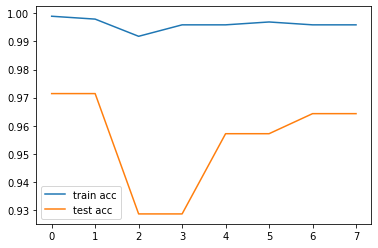

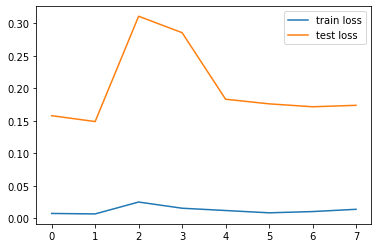

In [39]:
plt.plot(hist.history["accuracy"],label="train acc")
plt.plot(hist.history["val_accuracy"],label="test acc")
plt.legend()
plt.show()

plt.plot(hist.history["loss"],label="train loss")
plt.plot(hist.history["val_loss"],label="test loss")
plt.legend()
plt.show()